In [1]:
import os
import cv2
import numpy
import pandas
import pickle
import matplotlib.pyplot as plt
from torchvision import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
### Constants
DATA_PATH = "./dataset_complete/train_data" # path to the dataset
LABEL_PATH = './media/labels.csv' # path to the labels csv file
RESULT_PATH = "xx_core" # path to the labels csv file
BATCH_SIZE_VAL = 50 # size of batches during training
STEPS_X_EPOCH = 2000 # number of steps per epoch
N_EPOCHS = 100 # number of epochs for training
IMG_DIM = (32,32,3) # dimensions of the images (height, width, channels)
TEST_DATA = 0.1 # proportion of the data to use for testing (1000 images split will 200)
VAL_DATA = 0.1 # proportion of training data to use for validation (1000 images 20% of remaining 800 will be 160 for validation)

In [3]:
### Functions
def grayscale(img):
	"""function to convert the image to grayscale"""
	if len(img.shape) == 2: # if image is already grayscale
		return img # return it as is
	else:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
		return img

def equalize(img):
	"""function to equalize the histogram for contrast adjustment"""
	img = img.astype(numpy.uint8) # ensure the image is 8-bit grayscale
	img = cv2.equalizeHist(img) # apply histogram equalization
	return img

In [4]:
def preprocessing(img):
	"""function to preprocess the image"""
	img = grayscale(img) # convert to grayscale
	img = equalize(img) # equalize histogram
	img = img / 255 # normalize pixel values to the range [0, 1] instead of [0, 255]
	return img

In [5]:
def t_sign_model(n_classes):
	"""Defines the CNN model."""
	n_classes = n_classes
	n_kernels = 60
	n_nodes = 500
	kernel_size_5x5 = (5, 5)
	kernel_size_3x3 = (3, 3)
	pool_size = (2, 2)
	dropout_rate = 0.5
	learning_rate = 0.001
	model = Sequential()

	# First convolutional block
	model.add(Conv2D(n_kernels, kernel_size_5x5, input_shape=(IMG_DIM[0], IMG_DIM[1], 1), activation='relu'))
	model.add(Conv2D(n_kernels, kernel_size_5x5, activation='relu'))  # 2nd conv layer
	model.add(Conv2D(n_kernels, kernel_size_5x5, activation='relu'))  # 2nd conv layer
	model.add(MaxPooling2D(pool_size=pool_size))  # max pooling layer

	# Second convolutional block
	model.add(Conv2D(n_kernels, kernel_size_3x3, activation='relu'))  # 2nd conv layer
	model.add(Conv2D(n_kernels, kernel_size_3x3, activation='relu'))  # 2nd conv layer
	model.add(Conv2D(n_kernels, kernel_size_3x3, activation='relu'))  # 2nd conv layer
	model.add(MaxPooling2D(pool_size=pool_size))  # max pooling layer
	model.add(Dropout(dropout_rate))  # dropout layer

	# Fully connected layers
	model.add(Flatten())  # flatten the output for the fully connected layer
	model.add(Dense(n_nodes, activation='relu'))  # fully connected layer
	model.add(Dropout(dropout_rate))  # dropout layer
	model.add(Dense(n_classes, activation='softmax'))  # output layer

	# Compile the model
	model.compile(optimizer=Adam(learning_rate=learning_rate), 
				loss='categorical_crossentropy', 
				metrics=['accuracy'])
	return model

In [6]:
# importing of the Images
class_id = 0 # index for classes
images = [] # list for image data
class_labels = [] # list for class labels
labels = pandas.read_csv(LABEL_PATH) # read the labels csv file
n_classes = len(labels) # total number of classes
print("Total Classes Detected:", n_classes)

# load the images
print("Importing Classes:")
for x in range (0, n_classes):
    imgs = os.listdir(DATA_PATH+"/"+str(class_id)) # list images in class folder

    for y in imgs: # loop through each image
        # Skip hidden files like .DS_Store
        if y.startswith('.'):
            continue

        cur_img = cv2.imread(DATA_PATH+"/"+str(class_id)+"/"+y) # read image

        # Check if image was loaded successfully
        if cur_img is not None:
            cur_img = cv2.resize(cur_img, (IMG_DIM[0], IMG_DIM[1])) # resize to IMG_DIM
            images.append(cur_img) # add image to the list
            class_labels.append(class_id) # add class label
        else:
            print(f"Failed to load image: {DATA_PATH}/{class_id}/{y}")

    print(class_id, end =" ") # print class index
    class_id += 1
print()

images = numpy.array(images) # convert list of images to numpy array
class_labels = numpy.array(class_labels) # convert list of class labels to numpy array

Total Classes Detected: 38
Importing Classes:
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 


In [7]:
# split Data
    # X_train = array of images to train
    # y_train = corresponding class IDs
    # X_test = array of images to test
    # y_test = corresponding class IDs

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, class_labels, test_size=TEST_DATA)
# further split training data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(images, class_labels, test_size=VAL_DATA)

# print the shapes of the datasets
print("Data Shapes")
print(f"Total imgs {sum([len(files) for r, d, files in os.walk("./dataset_complete/")])}")
print("Train", X_train.shape, y_train.shape) # print training data shape
print("Validation", X_validation.shape, y_validation.shape) # print validation data shape
print("Test", X_test.shape, y_test.shape) # print test data shape

# # check if the number of images matches the number of labels for each dataset
# print(f"X_train: {X_train.shape[0]}, y_train: {y_train.shape[0]}")
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels in the training set"
# print(f"X_validation: {X_validation.shape[0]}, y_validation: {y_validation.shape[0]}")
assert(X_validation.shape[0] == y_validation.shape[0]), "The number of images is not equal to the number of labels in the validation set"
# print(f"X_test: {X_test.shape[0]}, y_test: {y_test.shape[0]}")
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels in the test set"

# check if the image dimensions are correct
assert(X_train.shape[1:] == (IMG_DIM)), "The dimensions of the training images are wrong"
assert(X_validation.shape[1:] == (IMG_DIM)), "The dimensions of the validation images are wrong"
assert(X_test.shape[1:] == (IMG_DIM)), "The dimensions of the test images are wrong"

Data Shapes
Total imgs 39312
Train (35344, 32, 32, 3) (35344,)
Validation (3928, 32, 32, 3) (3928,)
Test (3928, 32, 32, 3) (3928,)


data shape  (38, 2) <class 'pandas.core.frame.DataFrame'>
[160, 1747, 1754, 1092, 1571, 1457, 1140, 1063, 1151, 978, 1681, 1698, 723, 581, 656, 1501, 1445, 308, 507, 785, 570, 792, 446, 1201, 484, 1470, 693, 325, 1190, 345, 818, 597, 929, 574, 283, 1605, 425, 599]


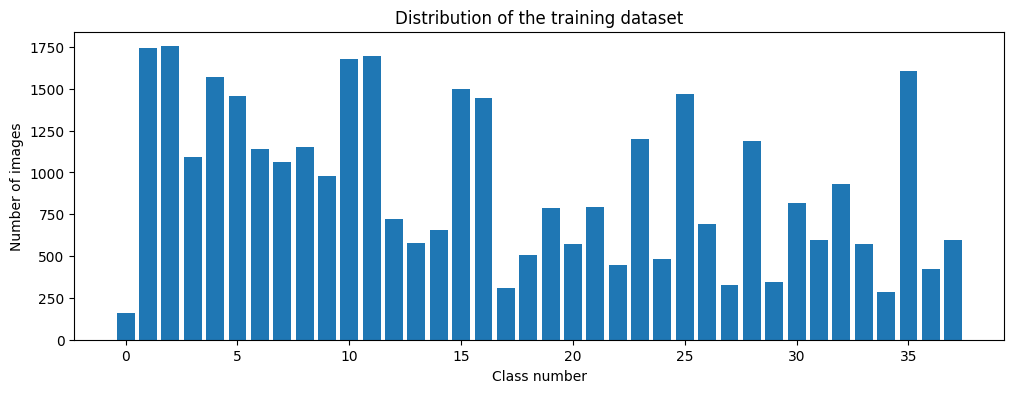

In [8]:
# read the label data from csv file
print("data shape ", labels.shape, type(labels))

# display some sample images from each class

sample_x_class = [] # list for the number of samples per class
n_cols = 5 # number of columns for displaying images

# loop through and display images
for i in range(n_cols):
    for j, row in labels.iterrows(): # iterate over rows in the labels
        x_selected = X_train[y_train == j] # select images from the current class

        if i == 2:
            sample_x_class.append(len(x_selected)) # add the number of samples for this class

# plot the distribution of training dataset
print(sample_x_class)
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), sample_x_class) # create a bar chart for sample distribution
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [9]:
# preprocess training, validation, and test sets
X_train = numpy.array(list(map(preprocessing, X_train)))
X_validation = numpy.array(list(map(preprocessing, X_validation)))
X_test = numpy.array(list(map(preprocessing, X_test)))

# reshape the data to add a depth of 1 (grayscale images have only one channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [10]:
print(f"X_train {X_train}")
print(f"y_train {y_train}")
print(f"X_validation {X_validation}")
print(f"y_validation {y_validation}")
print(f"X_test {X_test}")
print(f"y_test {y_test}")

X_train [[[[0.27058824]
   [0.50980392]
   [0.77254902]
   ...
   [0.9254902 ]
   [0.88627451]
   [0.89803922]]

  [[0.22352941]
   [0.49019608]
   [0.79607843]
   ...
   [0.94509804]
   [0.89411765]
   [0.94509804]]

  [[0.16470588]
   [0.47058824]
   [0.80784314]
   ...
   [0.91764706]
   [0.91764706]
   [0.98039216]]

  ...

  [[0.43529412]
   [0.61176471]
   [0.59607843]
   ...
   [0.84313725]
   [0.93333333]
   [0.97254902]]

  [[0.3372549 ]
   [0.56470588]
   [0.70196078]
   ...
   [0.85882353]
   [0.90588235]
   [0.94901961]]

  [[0.27058824]
   [0.51764706]
   [0.74509804]
   ...
   [0.85882353]
   [0.91764706]
   [0.94117647]]]


 [[[0.2745098 ]
   [0.23921569]
   [0.3372549 ]
   ...
   [0.08235294]
   [0.23921569]
   [0.12156863]]

  [[0.3372549 ]
   [0.22352941]
   [0.30588235]
   ...
   [0.11372549]
   [0.32941176]
   [0.2       ]]

  [[0.32941176]
   [0.22352941]
   [0.16078431]
   ...
   [0.24705882]
   [0.28235294]
   [0.31764706]]

  ...

  [[0.00392157]
   [0.00392157]

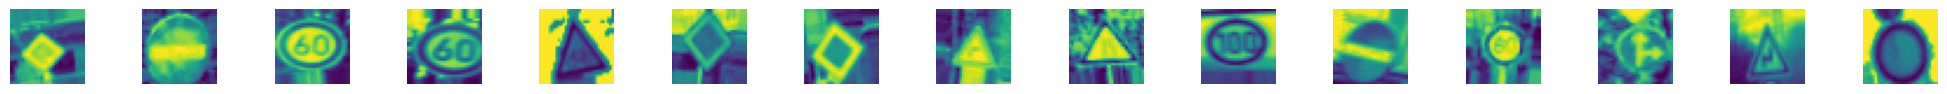

In [11]:
# augmentation of images to make the model more robust

# create an image data generator for augmenting the training data
img_gen = ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally by 10%
                            height_shift_range=0.1, # randomly shift images vertically by 10%
                            zoom_range=0.2, # randomly zoom in or out
                            shear_range=0.1, # randomly shear the images
                            rotation_range=10) # randomly rotate images by up to 10 degrees
img_gen.fit(X_train) # fit the generator on the training data
batches = img_gen.flow(X_train, y_train, batch_size=20) # generate augmented images
X_batch, y_batch = next(batches) # get the next batch

# display some augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(IMG_DIM[0], IMG_DIM[1])) # reshape to 32x32 and display
    axs[i].axis('off') # hide axis (for cleaner display)
plt.show()

# convert labels to one-hot encoded format
y_train = to_categorical(y_train, n_classes)
y_validation = to_categorical(y_validation, n_classes)
y_test = to_categorical(y_test, n_classes)

In [12]:
# build and train the model
from torch import nn
from torchsummary import summary
def nn_model(n_classes):
	"""Defines the CNN model."""
	n_kernels = 60
	n_nodes = 500
	kernel_size_5x5 = (5, 5)
	kernel_size_3x3 = (3, 3)
	pool_size = (2, 2)
	dropout_rate = 0.5
	model = nn.Sequential(
		# First convolutional block
		nn.Conv2d(1, n_kernels, kernel_size=kernel_size_5x5, padding=2), # 1 channel (grayscale)
		nn.ReLU(),
		nn.Conv2d(n_kernels, n_kernels, kernel_size=kernel_size_5x5, padding=2),
		nn.ReLU(),
		nn.Conv2d(n_kernels, n_kernels, kernel_size=kernel_size_5x5, padding=2),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=pool_size), # Max pooling layer

		# Second convolutional block
		nn.Conv2d(n_kernels, n_kernels, kernel_size=kernel_size_3x3, padding=1),
		nn.ReLU(),
		nn.Conv2d(n_kernels, n_kernels, kernel_size=kernel_size_3x3, padding=1),
		nn.ReLU(),
		nn.Conv2d(n_kernels, n_kernels, kernel_size=kernel_size_3x3, padding=1),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=pool_size), # Max pooling layer
		nn.Dropout(dropout_rate), # Dropout layer

		# Fully connected layers
		nn.Flatten(), # Flatten the output from convolutional layers
		nn.Linear(n_kernels * 8 * 8, n_nodes), # Fully connected layer
		nn.ReLU(),
		nn.Dropout(dropout_rate), # Dropout layer
		nn.Linear(n_nodes, n_classes), # Output layer
		nn.Softmax(dim=1)
	)

	return model

model = nn_model(n_classes)
summary(model, (1, IMG_DIM[0], IMG_DIM[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 60, 32, 32]           1,560
              ReLU-2           [-1, 60, 32, 32]               0
            Conv2d-3           [-1, 60, 32, 32]          90,060
              ReLU-4           [-1, 60, 32, 32]               0
            Conv2d-5           [-1, 60, 32, 32]          90,060
              ReLU-6           [-1, 60, 32, 32]               0
         MaxPool2d-7           [-1, 60, 16, 16]               0
            Conv2d-8           [-1, 60, 16, 16]          32,460
              ReLU-9           [-1, 60, 16, 16]               0
           Conv2d-10           [-1, 60, 16, 16]          32,460
             ReLU-11           [-1, 60, 16, 16]               0
           Conv2d-12           [-1, 60, 16, 16]          32,460
             ReLU-13           [-1, 60, 16, 16]               0
        MaxPool2d-14             [-1, 6

In [19]:
# from package import *
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch import optim
import time
import torch

# Function to create batches
def get_batches(X, y, batch_size):
	for i in range(0, len(X), batch_size):
		yield X[i:i+batch_size], y[i:i+batch_size]

# Funzione di addestramento
def train(model, X_train, y_train, optimizer, epoch):
	model.train()
	epoch_loss = 0
	correct = 0
	total = 0
	start_time = time.time()

	for batch_idx, (data, target) in enumerate(get_batches(X_train, y_train, BATCH_SIZE_VAL)):
		batch_start_time = time.time()
		optimizer.zero_grad()
		output = model(data)
		loss = F.cross_entropy(output, target)
		loss.backward()
		optimizer.step()
		epoch_loss += loss.item()

		# Calcola l'accuratezza
		_, predicted = torch.max(output, 1)
		total += target.size(0)
		correct += (predicted == target).sum().item()

		batch_end_time = time.time()
		batch_elapsed_time = batch_end_time - batch_start_time
		total_elapsed_time = batch_end_time - start_time
		if batch_idx % 10 == 0:
			print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(X_train)} ({100. * batch_idx / (len(X_train) / BATCH_SIZE_VAL):.0f}%)]\t  Loss: {loss.item():.6f},  Batch Time: {batch_elapsed_time:.2f} seconds,  Total Time: {total_elapsed_time:.2f} seconds', end='\r')

	# Calcola l'accuratezza media per l'epoca
	accuracy = 100. * correct / total
	# Tempo totale per tutta l'epoca
	epoch_end_time = time.time()
	total_epoch_time = epoch_end_time - start_time

	print(f'\nTrain Epoch: {epoch} - Average loss: {epoch_loss / (len(X_train) / BATCH_SIZE_VAL):.6f}, Accuracy: {accuracy:.2f}%, Total Time: {total_epoch_time:.2f} seconds')

	return epoch_loss / (len(X_train) / BATCH_SIZE_VAL), accuracy

# Funzione di test o validazione
def test(model, X_test, y_test):
	model.eval()
	test_loss = 0
	correct = 0
	start_time = time.time()
	with torch.no_grad():
		for data, target in get_batches(X_test, y_test, BATCH_SIZE_VAL):
			output = model(data)
			test_loss += F.cross_entropy(output, target, reduction='sum').item()
			pred = output.argmax(dim=1, keepdim=True)
			correct += pred.eq(target.view_as(pred)).sum().item()
	end_time = time.time()  
	test_loss /= len(X_test)
	accuracy = 100. * correct / len(X_test)
	print(f'Test/Validation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(X_test)} ({accuracy:.2f}%) - Time: {end_time - start_time:.2f} seconds')
	return test_loss, accuracy 

best_val_loss = 0
epochs_no_improve = 0
total_real_epoch = 0
train_accurs = []
val_accurs = []
train_losses = []
val_losses = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(1, N_EPOCHS + 1):
	total_real_epoch += 1
	print(f'\nEpoch {epoch}')
	# Allenamento del modello
	train_loss, train_accuracy = train(model, X_train, y_train, optimizer, epoch)
	train_losses.append(train_loss)
	train_accurs.append(train_accuracy)

	# Test del modello e calcolo della loss e dell'accuracy
	val_loss, val_accuracy = test(model, X_test, y_test)
	val_losses.append(val_loss)
	val_accurs.append(val_accuracy)

	# Aggiornamento del learning rate
	scheduler.step()
	current_lr = scheduler.get_last_lr()[0]
	print(f"Current learning rate: {current_lr:.6f}")

	# Salvataggio del miglior modello basato sulla loss
	if val_loss < best_val_loss:
		best_val_loss = val_loss
		best_model_state = model.state_dict()
		best_val_accuracy = val_accuracy
		epochs_no_improve = 0
		print(f"New best model found! Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

		# Salva i pesi del miglior modello
		torch.save(best_model_state, RESULT_PATH+'.pth')
		print(f"Best model weights saved with validation loss: {best_val_loss:.4f} and validation accuracy: {best_val_accuracy:.2f}%")
	else:
		epochs_no_improve += 1
		print("Epoch without improvment: " + str(epochs_no_improve))

	# Controllo se fermarmi
	if epochs_no_improve >= 10:
		print("Early stopping")
		break


Epoch 1


RuntimeError: Given groups=1, weight of size [60, 1, 5, 5], expected input[50, 32, 32, 1] to have 1 channels, but got 32 channels instead

In [ ]:
# # Save the best model based on validation accuracy
# checkpoint = ModelCheckpoint(
# 	filepath=RESULT_PATH+".keras", # File path to save the best model
# 	monitor="val_accuracy", # Metric to monitor
# 	mode="max", # 'max' since we want the highest validation accuracy
# 	save_best_only=True, # Save only when validation accuracy improves
# 	verbose=1 # Print a message when saving the model
# )

# # Stop training when validation accuracy has stopped improving for 'patience' epochs
# early_stopping = EarlyStopping(
# 	monitor="val_accuracy", # Metric to monitor
# 	mode="max", # Stop when this metric stops improving
# 	patience=10, # Number of epochs with no improvement after which training will stop
# 	restore_best_weights=True, # Restore the weights of the best model at the end of training
# 	verbose=1 # Print a message when stopping
# )

# # build and train the model
# model = t_sign_model(n_classes)
# print(model.summary())

# history = model.fit(
#     img_gen.flow(X_train, y_train, batch_size=BATCH_SIZE_VAL), # train the model using data augmentation
#     steps_per_epoch=STEPS_X_EPOCH, # number of steps per epoch
#     epochs=N_EPOCHS, # number of epochs
#     validation_data=(X_validation, y_validation), # validation data
# 	shuffle=True, # shuffle data during training
# 	callbacks=[early_stopping, checkpoint] # use the early stopping callback
# )

In [ ]:
# plot the training and validation loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

# plot the training and validation accuracy
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Get the last values of validation loss
last_val_loss = history.history['val_loss'][-1]
print(f'Last Validation Loss: {last_val_loss}')

# Get the last values of validation accuracy
last_val_accuracy = history.history['val_accuracy'][-1]
print(f'Last Validation Accuracy: {last_val_accuracy}')


# evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0]) # print test loss
print('Test Accuracy:', score[1]) # print test accuracy


In [ ]:
# # save the trained model
# pickle_out = open(RESULT_PATH+".p", "wb")
# pickle.dump(model, pickle_out) # serialize and save the model
# pickle_out.close()